In [318]:
from tokenizers import Tokenizer
from datasets import load_dataset
import json
from tqdm import tqdm

In [319]:
def pack_token(id, space, upper):
    return (id << 2) + (space << 1) + (upper << 0) 

def unpack_token(token):
    id = token >> 2
    space = bool((token >> 1) & 0x01)
    upper = bool((token >> 0) & 0x01)
    return (id, space, upper)

def upper_first(text):
    return text[0].upper() + (text[1:] if len(text) > 1 else "")

def lower_first(text):
    return text[0].lower() + (text[1:] if len(text) > 1 else "")

In [320]:
with open('tokenizers/tokenizer-space-50000-full-vocab.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

def expand_vocab(vocab, max_vocab_size):
    updated_vocab = {}
    for i, (token, id) in enumerate(vocab.items()):
        if i >= max_vocab_size:
            return updated_vocab
        updated_vocab[f"{upper_first(token)}"] = pack_token(id, space=False, upper=True)
        updated_vocab[f"Ġ{upper_first(token)}"] = pack_token(id, space=True, upper=True)
        updated_vocab[f"{token}"] = pack_token(id, space=False, upper=False)
        updated_vocab[f"Ġ{token}"] = pack_token(id, space=True, upper=False)
    return updated_vocab

vocab_size = 27500 + 257
vocab = expand_vocab(data["model"]["vocab"], max_vocab_size=vocab_size)
vocab_decode = {v:k for k,v in vocab.items()}


sorted_keys = sorted(vocab.keys(), key=lambda x: (len(x), x), reverse=True)
vocab_encode = {key: vocab[key] for key in sorted_keys}

print(vocab_decode[0])
print(len(vocab))


<|endoftext|>
108046


In [321]:
class TrieNode:
    def __init__(self):
        self.children = {}
        self.token_id = None
        self.token = None

class Trie:
    def __init__(self):
        self.root = TrieNode()

    def insert(self, token, token_id):
        node = self.root
        for char in token:
            if char not in node.children:
                node.children[char] = TrieNode()
            node = node.children[char]
        node.token_id = token_id
        node.token = token

    def search(self, text, start_pos):
        match_token, match_token_id = None, None
        pos = start_pos
        node = self.root
        while True:
            char = text[pos]
            if char not in node.children:
                break
            node = node.children[char]
            if node.token:
                match_token = node.token
                match_token_id = node.token_id
            pos += 1
            if pos >= len(text):
                break
        return match_token_id, match_token


# TODO handle space seperatly to cut tree in half
trie = Trie()
for token, token_id in vocab.items():
    trie.insert(token, token_id)

text = "thereĠisĠaĠcat"
token_id, token = trie.search(text, 5)
print(f"Token ID: {token_id}, Token: {token}")


Token ID: 1110, Token: Ġis


In [322]:
dataset = load_dataset("wikitext", "wikitext-103-raw-v1", split="test+validation") # split="train+test+validation"

def batch_iterator(batch_size=1000):
    for i in range(0, len(dataset), batch_size):
        yield dataset[i : i + batch_size]["text"]

In [323]:

# From https://github.com/openai/gpt-2/blob/master/src/encoder.py
def bytes_to_unicode():
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))

byte_encoder = bytes_to_unicode()
byte_decoder = {v:k for k, v in byte_encoder.items()}
print(len(byte_encoder))
print(byte_encoder.values())

256
dict_values(['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '®', '¯', '°', '±', '²', '³', '´', 'µ', '¶', '·', '¸', '¹', 'º', '»', '¼', '½', '¾', '¿', 'À', 'Á', 'Â', 'Ã', 'Ä', 'Å', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Ë', 'Ì', 'Í', 'Î', 'Ï', 'Ð', 'Ñ', 'Ò', 'Ó', 'Ô', 'Õ', 'Ö', '×', 'Ø', 'Ù', 'Ú', 'Û', 'Ü', 'Ý', 'Þ', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ð', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', '÷', 'ø', 'ù', 'ú', 'û', 'ü', 'ý', 'þ', 'ÿ', 'Ā', 'ā', 'Ă', 'ă', 'Ą', 'ą', 'Ć', 'ć', 'Ĉ

In [324]:
def encode(text):
    text = ''.join(byte_encoder[b] for b in text.encode('utf-8'))
    pos = 0
    ids, tokens = [], []
    while pos < len(text):
        id, token = trie.search(text, pos)
        if id is None or token is None:
            print(f'Error encoding "{text[pos-2:pos+16]}"')
            id, token = 0, "?"
        ids.append(id)
        tokens.append(token)
        pos += len(token)
        if pos >= len(text):
            break
    return ids, tokens

def decode(ids):
    out = ""
    for id in ids:
        if id in vocab_decode:
            out += vocab_decode[id]
        else:
            print(f"Error decoding {id}")
    return bytearray([byte_decoder[c] for c in out]).decode('utf-8', errors="replace")


text = "The quick brown Fox jumps 1234 OVER the lazy Dog."
ids, tokens = encode(text)
decoded = decode(ids)

print(text)
print(ids)
print(tokens)
print(decoded)

The quick brown Fox jumps 1234 OVER the lazy Dog.
[1037, 8598, 7638, 12427, 70294, 58618, 80, 92459, 89749, 1038, 90350, 12179, 56]
['The', 'Ġquick', 'Ġbrown', 'ĠFox', 'Ġjumps', 'Ġ123', '4', 'ĠOV', 'ER', 'Ġthe', 'Ġlazy', 'ĠDog', '.']
The quick brown Fox jumps 1234 OVER the lazy Dog.


In [325]:
with open('tokenizers/taylorswift.txt', 'r') as file:
    content = file.read()

ids, tokens = encode(content)
decoded = decode(ids)
token_count = len(ids)

print(token_count)
print(content == decoded)


52901
True


In [326]:
tokenizer_gpt = Tokenizer.from_file("tokenizers/tokenizer-gpt2-downgrade.json")
output_gpt = tokenizer_gpt.encode(content)
gpt_token_count = len(output_gpt.ids)

print("Space:", token_count, "GPT2:", gpt_token_count, "Ratio:", token_count / gpt_token_count)

Space: 52901 GPT2: 56758 Ratio: 0.9320448218753303


In [327]:
token_count, token_count_gpt = 0, 0
ids = []
for batch in tqdm(batch_iterator()):
    text = " ".join(batch)

    output = tokenizer_gpt.encode(text)
    token_count_gpt += len(output.ids)

    tokids, tokens = encode(text)
    ids.extend(tokids)
    token_count += len(tokids)

# 30000: 1.003, 32000: 0.9997 35000: 0.9949, 37500: 0.991
print("Token count", token_count, token_count_gpt, token_count / token_count_gpt)

9it [00:02,  3.37it/s]

Token count 505616 507954 0.9953972210082015


0.7314932911586144 19601


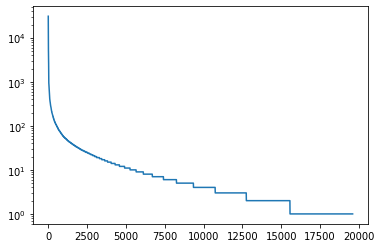

In [332]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(ids, columns=["id"])
# print(df)
df['id'] = df['id'] // 4
df = df['id'].value_counts().rename_axis('id').reset_index(name='counts')
# print(df)

print(len(df[df["counts"] <= 10]) / len(df), len(df))

plt.plot(range(len(df)), df["counts"])
plt.yscale("log")
plt.show()

In [330]:
with open('tokenizers/wikitext-val.txt', 'w', encoding='utf-8') as f:
    f.write("".join(byte_encoder.values()))
    f.write("\n".join(dataset["text"]))

In [331]:
# Downgrade huggingface tokenizer config, config is created from main branch of tokenizers

with open('tokenizers/tokenizer-gpt2.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

data["model"]["merges"] = list(map(lambda merge: f"{merge[0]} {merge[1]}", data["model"]["merges"]))

with open('tokenizers/tokenizer-gpt2-downgrade.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)